# Preamble

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart
import gsw

def cnorm(vm):
    return colors.Normalize( vmin=-vm,vmax=vm )

def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def mosaic_llc(field):
    return np.vstack([np.hstack([np.vstack([np.rot90(field[i]) for i in [9,8,7]]),
                                 np.vstack([np.rot90(field[i]) for i in [12,11,10]]),
                                 np.vstack([field[i] for i in [0,1,2]]),
                                 np.vstack([field[i] for i in [3,4,5]])]),
                      np.hstack([np.rot90(field[6])*np.tri(90)[::-1,:],np.triu(np.rot90(field[6],k=2))*np.tri(90)[::-1,:],
                                 np.triu(np.rot90(field[6],k=-1)),np.zeros(field[6].shape)])])[30:315,:]

def llc13to5faces(field):
    """
    fld = llc13to5faces(field) returns a list of 5 faces constructed from 
    the input of a 13-faces field as returned from 
    xmitgcm.open_mdsdataset(...,geometry='llc')
    """
    return [np.vstack((field[0,...],field[1,...],field[2,...])),
            np.vstack((field[3,...],field[4,...],field[5,...])),
            field[6,...],
            np.hstack((field[7,...],field[8,...],field[9,...])),
            np.hstack((field[10,...],field[11,...],field[12,...]))]

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

def calc_drake_passage_transport(ds):
    vtrans = (ds.VVEL*ds.hFacS*ds.drF).sum('k')*ds.dxG * 1e-6
    return (vtrans.sel(face=11,i=range(87,90),j_g=62).sum('i') + vtrans.sel(face=12,i=range(20),j_g=62).sum('i'))

def make_masks(coords):
    global_mask = coords.hFacC.isel(k=0)
    global_mask[6,:,:]=0. # delete Arctic face
    global_mask[2,80:,60:]=0.
    global_mask[7,:,:13]=0.
    global_mask[10,:43,:11]=0.
    # remove Hudson
    global_mask[10,30:54,5:39] = 0.
    global_mask[10,30:62,10:39] = 0.
    #
    atlantic_mask = global_mask.where(coords.YC>-35).where( # Southern Ocean
        np.logical_and(coords.XC<20,coords.XC>-98)).where( # most of the non-Atlantic Ocean
        np.logical_or(coords.XC<0,np.logical_or(coords.YC<30,coords.YC>47))).where(
        np.logical_or(coords.XC<-9,np.logical_or(coords.YC<34,coords.YC>38))).where( # Strait of Gibraltar
        np.logical_or(coords.XC>-70,coords.YC>9)).where( # East Pacific
        np.logical_or(coords.XC>-84,coords.YC>14)).where( # Isthmus of Panama etc.
        np.logical_or(coords.XC>-90,coords.YC>18)).where(
        np.logical_or(coords.XC>-70,coords.YC<50)).fillna(0)
    indopacific_mask = (global_mask-atlantic_mask).where(
        np.logical_and(coords.YC>-35,coords.YC<70)).fillna(0)
    # remove Hudson
    indopacific_mask[10,10:,:39] = 0.
    # remove Med and parts of Arctic
    indopacific_mask[ 2,20:,29:84] = 0.
    # remove Bering strait and Chukchy Sea
    indopacific_mask[ 7,:,:14] = 0.
    return global_mask, atlantic_mask, indopacific_mask

def compute_moc(wflux):
    u0 = xr.concat( [xr.concat( [wflux.isel(face=0),wflux.isel(face=1),wflux.isel(face=2)], dim = 'j' ),
                     xr.concat( [wflux.isel(face=3),wflux.isel(face=4),wflux.isel(face=5)], dim = 'j' )], dim='i' )
    v0 = xr.concat( [xr.concat( [wflux.isel(face=7),wflux.isel(face=8),wflux.isel(face=9)], dim = 'i' ),
                     xr.concat( [wflux.isel(face=10),wflux.isel(face=11),wflux.isel(face=12)], dim = 'i' )], dim='j' )
    wflx = (np.concatenate((u0,np.rot90(v0,k=1,axes=(-2,-1))), axis=-1)).sum(axis=-1)
    # order of integration: from north to south because of Atlantic MOC, requires sign change
    mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    mocstrf[wflx==0]=0.
    return mocstrf

# load grid information into separate data set grid
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/albedo/home/mlosch/MITgcm/nils/llc90/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

# paths etc

In [2]:
deltat=1800.
ny, nx = 1170, 90

bdir='/albedo/work/projects/p_idemix_tr181/llc90'
gdir='/albedo/work/projects/p_idemix_tr181/llc90/grid'

rdir, supertitle, fname =os.path.join(bdir,'run22_test'), 'WAGHC, $\kappa_{GM}$ = visbeck', 'waghc_viscbeck'
#rdir, supertitle, fname =os.path.join(bdir,'run22_test/waghc_gmredi1000'), 'WAGHC, $\kappa_{GM}$ = visbeck', 'waghc_visbeck'
#rdir, supertitle, fname = os.path.join(bdir,'run16'), 'PHC, $\kappa_{GM}$ = Visbeck', 'phc_visbeck'
#rdir, supertitle, fname = os.path.join(bdir,'run22'), 'WAGHC, $\kappa_{GM}$ = Visbeck', 'waghc_visbeck'
rdir, supertitle, fname = os.path.join(bdir,'run23'), 'WAGHC, $\kappa_{GM}$ = 1000.', 'waghc_km1000'
#rdir, supertitle, fname = os.path.join(bdir,'run24'), 'PHC, $\kappa_{GM}$ = 600.', 'phc_kgm600'
#rdir, supertitle, fname = os.path.join(bdir,'run25'), 'PHC, $\kappa_{GM,min}$ = 300.', 'phc_kgm300'
#rdir, supertitle, fname = os.path.join(bdir,'run26'), 'PHC, $\kappa_{GM}$ = Visbeck, $\kappa_{Redi}=600', 'phc_kredi600'
#rdir, supertitle, fname = os.path.join(bdir,'run27'), 'PHC, $\kappa_{GM}$ = Visbeck, Kmin_horiz=0.', 'phc_kminhor0'
#rdir, supertitle, fname = os.path.join(bdir,'run28'), 'PHC, $\kappa_{GM}$ = 600., Kmin_horiz=0.', 'phc_kgm600_kminhor0'
rdir, supertitle, fname = os.path.join(bdir,'run29'), r'PHC, $\alpha$ = 0.015, Kmin_horiz=0.', 'phc_alpha0.015_kminhor0'
#rdir, supertitle, fname = os.path.join(bdir,'run30'), r'PHC, $\alpha$ = 0.010, Kmin_horiz=0.', 'phc_alpha0.010_kminhor0'
#rdir, supertitle, fname = os.path.join(bdir,'run31'), r'PHC, $\alpha$ = 0.005, Kmin_horiz=0.', 'phc_alpha0.005_kminhor0'
#rdir=os.path.join(bdir,'run16')
fdir='/albedo/home/mlosch/MITgcm/MITgcm/idemix_test/llc90/testfigs'
print(rdir)

/albedo/work/projects/p_idemix_tr181/llc90/run29


In [3]:
#del ds
#ds = open_mdsdataset(os.path.join(rdir),prefix=['diagsKPP', 'diags3D', 'diags2D'],
ds = open_mdsdataset(os.path.join(rdir),prefix=['diagsGGL90', 'diagsKrN2', 'diags3D', 'diags2D'],
                     delta_t=deltat,ref_date="1958-1-1 0:0:0",geometry='llc',ignore_unknown_vars=True)
coords = ds.coords.to_dataset().reset_coords()
#ds = ds.reset_coords(drop=True)
# We generate the extra metadata needed for multi-faceted grids

In [4]:
ds

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                           k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88,
                           l1_i: 87, time: 155)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    dxF                   (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.array<chunksize=(87,), meta=np.ndarray>
    iter                  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1958-07-02T12:00:00 ... 2035-...
Data variables: (12/18)
    GGL90TKE              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Lmx              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Prl              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Kr               (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Emn              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    IDEMgTKE              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    ...                    ...
    SALT                  (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    DRHODR                (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    UVEL                  (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    VVEL                  (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    WVEL                  (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    LaTr1RHO              (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(data_dir='/albedo/work/...

# density gradients / slopes

In [12]:
year = 0
savefigs = False
#
mytime = year - 1

ds0=ds.isel(time=mytime)

import seawater as sw
m2db = -9.81*1035*1e-4

s = ds0.SALT.values
p = np.tile(ds0.Z.values.reshape((len(ds0.k),1,1,1))*m2db,(1,s.shape[-3],s.shape[-2],s.shape[-1]))
t = sw.temp(s, ds0.THETA.values, p, pr=0)
rho = sw.dens(s,t,p)-1000.

#sigma2 = sw.pden(s,t,p,pr=2000.)-1000.

mskc = np.where(ds0.hFacC>0,1,0)
drhody = (rho-np.roll(rho,1,axis=-2))/grid.DYC.values * np.where(ds0.hFacW>0,1,0)
drhodx = (rho-np.roll(rho,1,axis=-1))/grid.DXC.values * np.where(ds0.hFacS>0,1,0)
mskw = (mskc*np.roll(mskc,1,axis=0))
mskw[0,...] = 0
# averages to w-points
drhodx = 0.5*( drhodx + np.roll(drhodx,-1,axis=-1) )*mskc # in x
drhodx = 0.5*( drhodx + np.roll(drhodx,-1,axis=-4) )*mskw # in z
drhody = 0.5*( drhody + np.roll(drhody,-1,axis=-1) )*mskc # in y 
drhody = 0.5*( drhody + np.roll(drhody,-1,axis=-4) )*mskw # in z
# slope
drhodh = drhodx**2 + drhody**2
dsigdr = -ds0.DRHODR
# smooth dsigdr
dsigdr = ( dsigdr + 0.25 * (  np.roll(dsigdr,1,axis=-1)+np.roll(dsigdr,-1,axis=-1)
                           + np.roll(dsigdr,1,axis=-2)+np.roll(dsigdr,-1,axis=-2) ) 
         / ( 1.0 + 0.25 * (  np.roll(mskw,1,axis=-1)+np.roll(mskw,-1,axis=-1)
                           + np.roll(mskw,1,axis=-2)+np.roll(mskw,-1,axis=-2) ) )
         )
dsigdr = np.maximum(dsigdr,0.)*mskw
slp = np.sqrt(drhodx**2 + drhody**2)/np.where(dsigdr!=0,dsigdr,np.Inf)

# plots

## define sections

In [13]:
def section170(ds,fld):
    jj=48 # XC = 169.5
#   jj=49 # XC = 168.5
    fldSection=np.concatenate((fld[:,7,jj,:],fld[:,8,jj,:],fld[:,9,jj,:]),axis=1)[:,:-30]
    y = np.concatenate(grid.YC[7:10,jj,:],axis=0)[:-30]
    d = np.concatenate(ds.Depth[7:10,jj,:],axis=0)[:-30]
    z = ds.Z.values
    return y, z, d, fldSection

def section30(ds,fld):
    ii=7
    iface=3
    fldSection=np.concatenate((fld[:,0,:,ii],fld[:,1,:,ii],fld[:,2,:,ii]),axis=1)
    y = np.concatenate(grid.YC[:iface,:,ii],axis=0)
    d = np.concatenate(ds.Depth[:iface,:,ii],axis=0)
    z = ds.Z.values
    return y, z, d, fldSection

def plotsec(ax, cax, data_x, data_y, data_v, contfs, fname):
    hm=ax.contourf(data_x, -data_y, data_v, levels=contfs, vmin=contfs[0], vmax=contfs[-1], 
                   cmap=cmap, norm=norm, extend='both')
    ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    ax.set_title('MITgcm-%s'%fname)
    plot_settings(ax=ax, template='section',xlim=[-80,60])
    # colorbar
    cbkwargs = dict(orientation='vertical', extend='both')
    cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
    cb.solids.set_edgecolor("face")
    cb.set_ticks(contfs[contfs!=0.0])
    cb.ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation())
    


## actual plot

/albedo/home/mlosch/MITgcm/MITgcm/idemix_test/llc90/testfigs/mitgcm_stability_phc_alpha0.015_kminhor0_155y.png


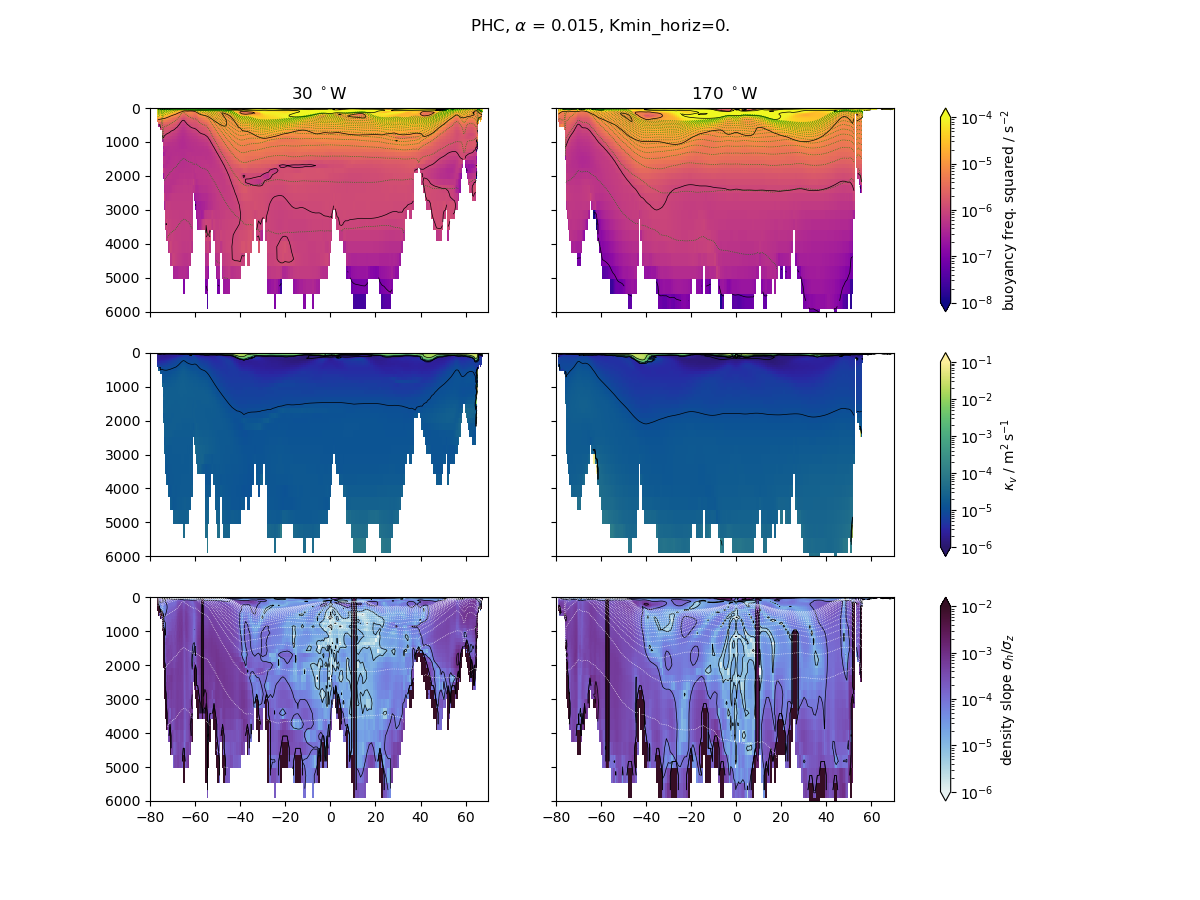

In [14]:
plt.close('all')
fig, ax = plt.subplots(3,2,sharex=True,sharey=True,figsize=(12,9))
#fig, ax = plt.subplots(3,2,sharex=True,sharey=True,figsize=(8,6))
ax = ax.ravel()

def plotit(ax,data_x, data_y, data_v, depth, cmap=None, norm=None, levels=None):
    landcolor = 'grey'
    hm=ax.pcolormesh(data_x, data_y, sq(data_v), cmap=cmap, norm=norm)
    ax.contour(data_x, data_y, sq(data_v), levels=contfs, colors = 'k', linewidths=0.5)
    #ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    return hm

#cab=gsw.cabbeling(ds.isel(time=mytime).SALT,ds.isel(time=mytime).THETA,-ds.Z*9.81*1035*1e-4)

symnorm=False
# N^2
cmap = plt.get_cmap('plasma')
data_x, data_y, depth, data_dens = section30(ds, ds0.LaTr1RHO.where(ds.hFacC>0))
data_x, data_y, depth, data_v    = section30(ds,-9.81/1035 * ds0.DRHODR)
data_y = -ds.Zu.data
n2norm = colors.LogNorm(vmin=1e-8,vmax=1e-4)
contfs=np.logspace(np.log10(n2norm.vmin), np.log10(n2norm.vmax), int(np.log10(n2norm.vmax)-np.log10(n2norm.vmin)+1))
if symnorm:
    n2norm = colors.SymLogNorm(linthresh=n2norm.vmin,linscale=0.1, vmin=-n2norm.vmax,vmax=n2norm.vmax)
    contfs = np.hstack((-contfs[::-1],contfs))
    cmap = cmo.balance
    #cmap = cmo.delta
    
dcontfs=np.linspace(35,37,21)

hm = plotit(ax[0],data_x, -ds.Zu.data, data_v, depth, cmap=cmap, norm=n2norm, levels=contfs)
cs = ax[0].contour(data_x,-ds.Z.data, sq(data_dens),levels=dcontfs,colors='g', linewidths=0.5, linestyles=':')
#ax[0].clabel(cs, cs.levels, inline=True, fontsize=10)

data_x, data_y, depth, data_dens = section170(ds,ds0.LaTr1RHO.where(ds.hFacC>0))
data_x, data_y, depth, data_v    = section170(ds,-9.81/1035 * ds0.DRHODR)
hm = plotit(ax[1],data_x, -ds.Zu.data, data_v, depth, cmap=cmap, norm=n2norm, levels=contfs)
cs = ax[1].contour(data_x, -ds.Z.data, sq(data_dens),levels=dcontfs,colors='g', linewidths=0.5, linestyles=':')
#___________________________________________________________________________________
# This is out of Niels pyicon.shade(...) routine
cbkwargs = dict(orientation='vertical', extend='both',label=r'buoyancy freq. squared / s$^{-2}$')
cb = plt.colorbar(hm, ax=ax[:2], ticks=contfs, **cbkwargs)

# diffusivities
#cmap = plt.get_cmap('plasma')
cmap = cmo.haline
norm = colors.LogNorm(1e-6,1e-1)
contfs=np.logspace(np.log10(norm.vmin), np.log10(norm.vmax), int(np.log10(norm.vmax)-np.log10(norm.vmin)+1))

#data_x, data_y, depth, data_v = section30(ds, ds0.KPPdiffT)
data_x, data_y, depth, data_v = section30(ds, ds0.GGL90Kr)
hm = plotit(ax[2],data_x, -ds.Zu.data, data_v, depth, cmap=cmap, norm=norm, levels=contfs)

#data_x, data_y, depth, data_v = section170(ds, ds0.KPPdiffT)
data_x, data_y, depth, data_v = section170(ds, ds0.GGL90Kr)
hm = plotit(ax[3],data_x, -ds.Zu.data, data_v, depth, cmap=cmap, norm=norm, levels=contfs)

cbkwargs = dict(orientation='vertical', extend='both',label=r'$\kappa_v$ / m$^{2}\,$s$^{-1}$')
cb = plt.colorbar(hm, ax=ax[2:4], ticks=contfs, **cbkwargs)

# slope
cmap = cmo.dense
data_x, data_y, depth, data_dens = section30(ds0,ds0.LaTr1RHO.where(ds.hFacC>0))
data_x, data_y, depth, data_v    = section30(ds0,slp)
data_y = -ds0.Zu.data
n2norm = colors.LogNorm(vmin=1e-6,vmax=1e-2)
contfs=np.logspace(np.log10(n2norm.vmin), np.log10(n2norm.vmax), int(np.log10(n2norm.vmax)-np.log10(n2norm.vmin)+1))
if symnorm:
    n2norm = colors.SymLogNorm(linthresh=n2norm.vmin,linscale=0.1, vmin=-n2norm.vmax,vmax=n2norm.vmax)
    contfs = np.hstack((-contfs[::-1],contfs))
    cmap = cmo.balance
    #cmap = cmo.delta
    
dcontfs=np.linspace(35,37,21)

hm = plotit(ax[4],data_x, -ds.Zu.data, sq(data_v), depth, cmap=cmap, norm=n2norm, levels=contfs)
cs = ax[4].contour(data_x,-ds.Z.data, sq(data_dens),levels=dcontfs,colors='w', linewidths=0.5, linestyles=':')
#ax[0].clabel(cs, cs.levels, inline=True, fontsize=10)


data_x, data_y, depth, data_dens = section170(ds,ds.LaTr1RHO.isel(time=mytime).where(ds.hFacC>0))
data_x, data_y, depth, data_v    = section170(ds,slp)
hm = plotit(ax[5],data_x, -ds.Zu.data, sq(data_v), depth, cmap=cmap, norm=n2norm, levels=contfs)
cs = ax[5].contour(data_x, -ds.Z.data, sq(data_dens),levels=dcontfs,colors='w', linewidths=0.5, linestyles=':')

cbkwargs = dict(orientation='vertical', extend='both',label=r'density slope $\sigma_h/\sigma_z$')
cb = plt.colorbar(hm, ax=ax[4:], ticks=contfs, **cbkwargs)

#     kn2norm = colors.SymLogNorm(linthresh=kn2norm.vmin,linscale=0.1, vmin=-kn2norm.vmax,vmax=kn2norm.vmax)
#     contfs = np.hstack((-contfs[::-1],contfs))
#     cmap = cmo.balance#,cmo.delta

# data_x, data_y, depth, data_v = section30(ds, ds0.GGL90KN2)
# hm = plotit(ax[4],data_x, -ds.Zu.data, data_v, depth, cmap=cmap, norm=kn2norm, levels=contfs)

# data_x, data_y, depth, data_v = section170(ds, ds0.GGL90KN2)
# hm = plotit(ax[5],data_x, -ds.Zu.data, data_v, depth, cmap=cmap, norm=kn2norm, levels=contfs)

# cbkwargs = dict(orientation='vertical', extend='both',label=r'$\kappa N^2$ / m$^{2}\,$s$^{-3}$')
# cb = plt.colorbar(hm, ax=ax[4:], ticks=contfs, **cbkwargs)
#___________________________________________________________________________________  
ax[0].set_title('30 $^\circ$W')
ax[1].set_title('170 $^\circ$W')
ax[0].set_xlim([-80,70])
ax[0].set_ylim([6000,0])
#plot_settings(ax=ax, template='section',xlim=[-80,60])

#cax.set_ylabel(f'buoyancy frequency squared / (1/s$^2$)\n along 170$^\circ$W')
#fig.show()
yrs = mytime+1
if yrs==0: yrs = len(ds.time)
fig.suptitle(supertitle)
ff = os.path.join(fdir,'mitgcm_stability_%s_%03iy.png'%(fname,yrs))
print(ff)
if savefigs: fig.savefig(ff)

In [8]:
# produce an error
ds1

NameError: name 'ds1' is not defined

In [ ]:
# produce an error:
ds.GM_VisbK.where(ds.hFacC[0,:,:,:]>0).max().values

In [ ]:
data_x, data_y, depth, data_theta = section30(ds,ds0.THETA)
data_x, data_y, depth, data_salt = section30(ds,ds0.SALT)
data_x, data_y, depth, data_dens = section30(ds,ds0.LaTr1RHO.where(ds.hFacC>0))


In [ ]:
nds = xr.Dataset(
    data_vars=dict( theta=(["z", "lat"], data_theta), salt=(["z", "lat"], data_salt),
                    sigma2=(["z", "lat"], data_dens) ),
    coords=dict( lat=(["lat"], data_x.astype('float64')), z=(["z"], data_y.astype('float64')), ),
    attrs=dict(description="hydrograph extracted from llc90 run"),
)

nds.to_netcdf('/albedo/home/mlosch/MITgcm/MITgcm/idemix_test/llc90/hydrollc90.nc')

In [ ]:
data_theta.shape

## LLCMapper

In [ ]:
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, lon_0=-60, tstr=None, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        x,y = self.new_grid_lon, self.new_grid_lat

        p = ax.pcolormesh(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)
        # p = ax.contourf(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)

        # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
        ax.add_feature(cart.feature.LAND, facecolor=landcolor, zorder=3)
        ax.add_feature(cart.feature.COASTLINE, zorder=4, edgecolor='k')
        gl = ax.gridlines(zorder=4)

        if tstr is not None:
            ax.set_title('%s'%(tstr))
            
        label = None
        # if da.name is not None:
        #     label = da.name
        # if 'units' in da.attrs:
        #     label += ' (%s)' % da.attrs['units']
        # cbarextend='both'
        # try:
        #     mynorm = plt_kwargs.pop('norm')
        #     if mynorm.vmin == 0.: cbarextend='max'
        # except:
        #     cbarextend='both'

        # shrinkfac=1.
        # cb = plt.colorbar(p, ax=ax, shrink=shrinkfac, label=label, extend=cbarextend, orientation='horizontal')

        return ax, p, gl
    
class LLCinterp:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(
            lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(
            lons=self.new_grid_lon, lats=self.new_grid_lat)

    def __call__(self, da):

        assert set(da.dims) == set(
            ['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100e3,
                                                    fill_value=None)
        return field

# Not used ...

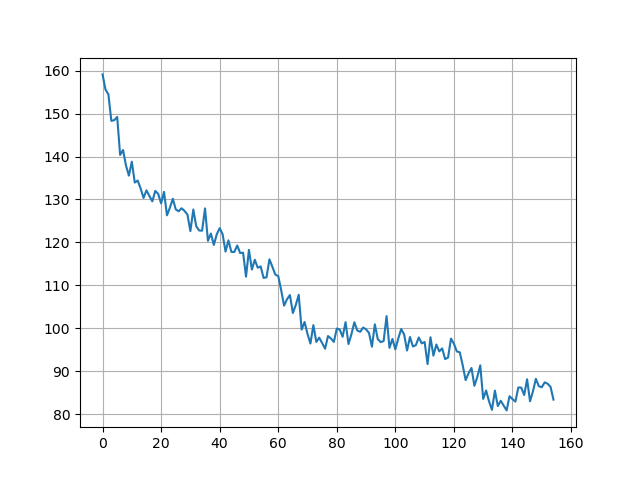

In [15]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
#amoc = compute_moc(ds.WVEL*(ds.rA*atlantic_mask)*1e-6)
dpt  = calc_drake_passage_transport(ds).values

plt.figure()
plt.plot(dpt)
plt.grid()

In [ ]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

proj=cart.crs.SouthPolarStereo()
proj=cart.crs.PlateCarree()
landcolor='0.7'
fig,ax=plt.subplots(1,1,subplot_kw={'projection': proj})

mapper = LLCMapper(coords)
bx, hm, gl = mapper(ds.isel(time=4).GM_VisbK,
                    ax=ax, 
                    tstr=("GM_VisbK"),
                    norm = colors.LogNorm(vmin=1,vmax=2500)) #contfs, extend=extnd, cmap=cmo.dense)
#bx.set_extent([-180, 180, -90, -50],cart.crs.PlateCarree())
#bx.set_boundary(circle, transform=bx.transAxes)
#gl.ylocator = mticker.FixedLocator(np.linspace(-90,-40,11))

cbkwargs = dict(orientation='horizontal') #, extend=extnd, label=clab)
cb = plt.colorbar(mappable=hm, ax=ax, **cbkwargs)
#cb.solids.set_edgecolor("face")


In [ ]:
# cause an error
ds1

In [ ]:
mask2d=(ds.hFacC.isel(k=0)!=0.).compute()
# create instance of LLC-mapper
mapper = LLCMapper(coords) #, dx=1., dy=1.)
llcintp = LLCinterp(coords)

In [ ]:
mytime = -1
sextent=None
#proj=cart.crs.EqualEarth() #central_longitude=180.0-19) #central_longitude=7.0)
#proj=cart.crs.Robinson() #central_longitude=180.0-19) #central_longitude=7.0)
proj=cart.crs.PlateCarree() #central_longitude=180.0-19) #central_longitude=7.0)
#sextent=[-180, 180, -90, -50]
# proj=cart.crs.SouthPolarStereo()

fig, ax = plt.subplots(3,1,sharex=True,sharey=True,figsize=(12,9),subplot_kw={'projection': proj})
ax = ax.ravel()

symnorm=True
landcolor = 0.7
myk=37
x,y = llcintp.new_grid.lons, llcintp.new_grid.lats
# N^2
cmap = plt.get_cmap('plasma')
data_x, data_y, depth, data_v = section30(ds,-9.81/1035 * ds.DRHODR.isel(time=mytime))
data_y = -ds.Zu.data
n2norm = colors.LogNorm(vmin=1e-8,vmax=1e-4)
contfs=np.logspace(np.log10(n2norm.vmin), np.log10(n2norm.vmax), int(np.log10(n2norm.vmax)-np.log10(n2norm.vmin)+1))
extnd = 'max'
if symnorm:
    n2norm = colors.SymLogNorm(linthresh=n2norm.vmin,linscale=0.1, vmin=-n2norm.vmax,vmax=n2norm.vmax)
    contfs = np.hstack((-contfs[::-1],contfs))
    cmap = cmo.balance
    extnd = 'both'

# buoyancy
n2d = -9.81/1035 * llcintp(ds.DRHODR.isel(time=mytime, k_l=myk))
#hm = ax[0].contourf(x,y,sq(n2d), norm=n2norm, levels = contfs, extend=extnd, cmap=cmap, transform = cart.crs.PlateCarree())
hm = ax[0].pcolormesh(x,y,sq(n2d), norm=n2norm, cmap=cmap, transform = cart.crs.PlateCarree())
cbkwargs = dict(orientation='vertical', extend='both',label=r'buoyancy freq. squared / s$^{-2}$')
cb = plt.colorbar(hm, ax=ax[0], ticks=contfs, **cbkwargs)

# diffusivity
cmap = cmo.haline
norm = colors.LogNorm(1e-5,1e0)
contfs=np.logspace(np.log10(norm.vmin), np.log10(norm.vmax), int(np.log10(norm.vmax)-np.log10(norm.vmin)+1))

diffkr2d = llcintp(ds.GGL90Kr.isel(time=mytime, k_l=myk))
hm = ax[1].pcolormesh(x,y,sq(diffkr2d), norm=norm, cmap=cmap, transform = cart.crs.PlateCarree())
cbkwargs = dict(orientation='vertical', extend='both',label=r'$\kappa_v$ / m$^{2}\,$s$^{-1}$')
cb = plt.colorbar(hm, ax=ax[1], ticks=contfs, **cbkwargs)

# k N^2
cmap = plt.get_cmap('plasma')
kn2norm = colors.LogNorm(vmin=1e-12,vmax=1e-8)
contfs=np.logspace(np.log10(kn2norm.vmin), np.log10(kn2norm.vmax), int(np.log10(kn2norm.vmax)-np.log10(kn2norm.vmin)+1))
if symnorm:
    kn2norm = colors.SymLogNorm(linthresh=kn2norm.vmin,linscale=0.1, vmin=-kn2norm.vmax,vmax=kn2norm.vmax)
    contfs = np.hstack((-contfs[::-1],contfs))
    cmap = cmo.balance#,cmo.delta

diffkn2d = llcintp(ds.GGL90KN2.isel(time=mytime, k_l=myk))
hm = ax[2].pcolormesh(x,y,sq(diffkn2d), norm=kn2norm, cmap=cmap, transform = cart.crs.PlateCarree())
cbkwargs = dict(orientation='vertical', extend='both',label=r'$\kappa N^2$ / m$^{2}\,$s$^{-3}$')
cb = plt.colorbar(hm, ax=ax[2], ticks=contfs, **cbkwargs)

for b in ax:
    #b.add_feature(cart.feature.LAND, facecolor=landcolor, zorder=3)
    b.add_feature(cart.feature.COASTLINE, zorder=4, edgecolor='k')
    b.gridlines(zorder=5)
    if sextent != None: b.set_extent(sextent,cart.crs.PlateCarree())
    
fig.suptitle('z = %f m'%abs(ds.Zl[myk]))

In [ ]:
#ds1 = open_mdsdataset(os.path.join(rdir1),delta_t=deltat,ref_date="1958-1-1 0:0:0",geometry='llc')
ds1

In [ ]:
plt.close('all')
mytime=-1
myk=20

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)


def myplot(ds,ax):
#    csf=ax.pcolormesh(sq(mosaic_llc(ds.WVEL.isel(time=mytime,k_l=myk))),vmin=-1e-4,vmax=1e-4); ax.set_title('WVEL at z(%i)=%5.1f m'%(myk,ds.Zl[myk]))
    csf=ax.pcolormesh(sq(mosaic_llc(ds.MXLDEPTH.isel(time=mytime).where(ds.hFacC.isel(k=0)>0))),vmax=500)
#    csf=ax.pcolormesh(sq(mosaic_llc(ds.GGL90TKE.isel(time=mytime,k_l=myk))),vmax=1e-2); ax.set_title('GG90TKE at z(%i)=%5.1f m'%(myk,ds.Zl[myk]))
#    csf=ax.pcolormesh(sq(mosaic_llc(ds.GGL90TKE.isel(time=mytime,k_l=myk))),vmax=1e-2); ax.set_title('GG90TKE at z(%i)=%5.1f m'%(myk,ds.Zl[myk]))
#     mycnorm = colors.LogNorm(vmin=1e-6,vmax=1e-1)
#     dz=(ds.hFacC*ds.drF).rename({"k": "k_l"})/ds.Depth.where(ds.Depth!=0)
#     fld2d = ((ds.GGL90TKE.isel(time=mytime))*dz).sum(axis=0)
# #    csf=ax.contourf(sq(mosaic_llc(fld2d)),norm=mycnorm,levels=np.logspace(-6,-1,21),extend='max')
#     csf=ax.pcolormesh(sq(mosaic_llc(fld2d)),norm=mycnorm)
    plt.colorbar(csf, ax=ax)

fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(18,6))#, subplot_kw={'projection': proj})
myplot(ds,ax[0])
myplot(ds1,ax[1])
#csf=ax[1].pcolormesh(sq(mosaic_llc(ds.MXLDEPTH.isel(time=mytime).where(ds.hFacC.isel(k=0)>0))),vmax=1500)
#csf=ax[1].pcolormesh(sq(mosaic_llc(ds.GGL90tau.isel(time=mytime).where(ds.hFacC.isel(k=0)>0))),norm=symNorm(1e-4))#,vmax=1500)
#plt.colorbar(csf, ax=ax[1])
#plt.title('MXLDEPTH')

In [ ]:
import cmocean.cm as cmo
#plt.close('all')
def plotsec(ax,ds,fld,cnorm,tstr='dummy',cmap=None):
    jj=59
    iface=8
    fld0 = fld.where(fld!=0.)
    y = np.concatenate(ds.YC[iface-1:iface+1,:,:],axis=1)[jj,:]
    d = np.concatenate(ds.Depth[iface-1:iface+1,:,:],axis=1)[jj,:]
    csf=ax.pcolormesh(y,ds.Z,np.concatenate((fld0[-1,:,iface-1,:,:],fld0[-1,:,iface,:,:]),axis=-1)[:,jj,:],norm=cnorm,cmap=cmap)
    ax.fill_between(y,-d,-ds.Depth.max(),step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal')
    ax.set_title('%s: section in face %i, along j_g=%i (%i E)'%(tstr,iface+1,jj+1,ds.XC.sel(face=iface,j=jj).mean()))

fig,ax=plt.subplots(2,2,figsize=(12,9),sharex=True,sharey=True);
plotsec(ax[0,0],ds,ds.VVEL,colors.Normalize(vmin=-1,vmax=1),'KPP: VVEL',cmap=cmo.delta)
#plotsec(ax[0,1],ds,ds.GGL90TKE,colors.LogNorm(vmin=1e-6,vmax=1e-2),'GGL90TKE')
plotsec(ax[1,0],ds,ds.THETA,colors.Normalize(vmin=-2,vmax=25),'KPP: THETA',cmap=cmo.thermal)
#plotsec(ax[1,1],ds,ds.GGL90Lmx.where(ds.GGL90Lmx>1e-6),colors.LogNorm(vmin=1e-1,vmax=300),'GGL90Lmx')
# plotsec(ax[0,1],ds1,ds1.VVEL,colors.Normalize(vmin=-1,vmax=1),'GGL90: VVEL',cmap=cmo.delta)
# plotsec(ax[1,1],ds1,ds1.THETA,colors.Normalize(vmin=-2,vmax=25),'GGL90: THETA',cmap=cmo.thermal)
plotsec(ax[0,1],ds1,(ds-ds1).VVEL,colors.Normalize(vmin=-.1,vmax=.1),'GGL90: VVEL',cmap=cmo.delta)
plotsec(ax[1,1],ds1,(ds-ds1).THETA,colors.Normalize(vmin=-.5,vmax=.5),'GGL90: THETA',cmap=cmo.balance)


for b in ax[1,:]: b.set_xlabel('Latitude (degN)')
for b in ax[:,0]: b.set_ylabel('Z (m)')


This seems to be my first successful attempt to use cartopy together with an LLC-grid without any tricks

In [ ]:
proj=cart.crs.Robinson(central_longitude=7.0)
proj=cart.crs.PlateCarree(central_longitude=180.0)
#fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(15,8),subplot_kw={'projection': cart.crs.Robinson(central_longitude=7.0)})
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(15,8),subplot_kw={'projection': proj})
ax.set_global()
#for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
for iface in range(13):
    clrbr=False
    if iface==12: clrbr=True
    fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", add_colorbar=clrbr) #, vmin=vmin,vmax=vmax)

In [ ]:
plt.close('all')
msk = ds.hFacC.isel(k=0)
# fld=ds.MXLDEPTH.where(ds.MXLDEPTH!=0.).isel(time=-1) #.isel(k=20)
# fld.plot(col='face', col_wrap=4 )#, norm = colors.LogNorm()) # ,vmax=1500)
mytime=-1
#plt.figure(1)
#fld=ds.ETAN.where(msk!=0.).isel(time=mytime) #.isel(k=20)
#fld.plot(col='face', col_wrap=4 )#, norm = colors.LogNorm()) # ,vmax=1500)
#plt.figure(2)
#fld=ds.MXLDEPTH.where(ds.MXLDEPTH!=0.).isel(time=mytime) #.isel(k=20)
#fld.plot(col='face', col_wrap=4, vmax = 1500)#, norm = colors.LogNorm()) # ,vmax=1500)
fld=ds.GGL90TKE.where(ds.GGL90TKE!=0.).isel(time=mytime).isel(k_l=10)
fld.plot(col='face', col_wrap=4,vmax=1e-3)

In [ ]:
#mflx=((ds.oceFWflx*ds.rA).sum(axis=(1,2,3))/(ds.rA*ds.maskC.isel(k=0)).sum()).values

# fh=plt.figure()
# plt.plot(mflx)

In [ ]:
plt.close('all')
# choose field
fld = (ds.MXLDEPTH).isel(time=-1).where(coords.hFacC.isel(k=0)!=0.)
print(fld.shape)
fld.isel(face=6).plot(vmax=500)


In [ ]:
vm=np.abs(fld).max().data.compute()
#vm=1e0
def cnorm(vm):
    import matplotlib.colors as colors
    return colors.Normalize( vmin=-vm,vmax=vm )
    #return colors.SymLogNorm(linthresh=vm*1e-5, linscale=1.,vmin=-vm,vmax=vm,base=10)

cmap='RdBu_r'
cmap=cmo.delta
# fld.values has the shape 13,90,90, convert to 5 faces first
xg = rdmds('../grid/XG') #llc.faces2mds(llc13to5faces(coords.XG.values))
yg = rdmds('../grid/YG') #llc.faces2mds(llc13to5faces(coords.YG.values))
fldllc = rdmds('diags2D',np.Inf)[3,:,:]# llc.faces2mds(llc13to5faces(fld.values)) #llc13to5faces(fld.values))
#vm=np.abs(fldllc).max()
extent = (xg.min(),xg.max(),yg.min(),yg.max())

clon=-20.0

proj = cart.crs.NorthPolarStereo(central_longitude=clon, globe=None) #Robinson(), 
#proj = cart.crs.Robinson() 
#proj=cart.crs.Orthographic(central_longitude=clon, central_latitude=70.0, globe=None)
data_proj=cart.crs.PlateCarree()
plt.close('all')
fig,ax=plt.subplots(1,1,sharex=True,sharey=True,subplot_kw={'projection': proj})
csf = llc.pcol(xg,yg,fldllc,transform=data_proj)#,cmap=cmap,vmin=-vm,vmax=vm,transform=data_proj)#, extent=extent)
plt.colorbar(orientation='horizontal')

In [ ]:
fld.values.shape

In [ ]:
#fid=open('/work/ollie/mlosch/raslyboca/datasets/CORE2_IAF/runoff_CORE2_iaf_monthly_1996','r')
fid=open('SSS_WPv3_M_eccollc_90x50_pm05atl.bin','r')
v=np.fromfile(fid,'>f4').reshape((12,ny,nx))
fid.close()

In [ ]:
plt.close();
xg=rdmds('../grid/XG')
yg=rdmds('../grid/YG')
#e=rdmds('test/EXF',np.Inf)
#llc.pcol(xg,yg,sq(e[12,:,:]))
llc.pcol(xg,yg,sq(v.mean(axis=0)))
plt.colorbar()
#e.shape

In [ ]:
sq(v).min()

In [ ]:
myiter = 17520//2
myiter = np.Inf
d=rdmds('test/diags3D',myiter)
e=rdmds('test/diags2D',myiter)
#s=rdmds('tmp/diagSeaice',myiter)
#ef=rdmds('EXF',myiter)
xg=rdmds('../grid/XG')
yg=rdmds('../grid/YG')
d.shape

In [ ]:
plt.close('all')
fig,ax=plt.subplots(1,1,subplot_kw={'projection': cart.crs.PlateCarree(central_longitude=0.0)})
#plt.figure()
#llc.pcol(xg,yg,sq(e[1,:,:]),vmax=1000)
csf = llc.pcol(xg,yg,sq(e[0,:,:]),transform=cart.crs.PlateCarree())#, extent=extent)
#pcol(sq(s[0,2*90:3*90,:]))
#plt.colorbar(csf[0])
#plt.show()
csf

compare two fields

In [ ]:
mytime=-1
fld=ds.ETAN.isel(time=mytime) #.isel(k=20)
vmin=fld.values.min()
vmax=fld.values.max()
fld=fld.where(ds.hFacC.isel(k=0)!=0.)

# xg=grid.XG.values
# xg[7:10,:,:]=np.where(xg[7:10,:,:]<0.,xg[7:10,:,:]+360.,xg[7:10,:,:])
# #grid.isel(face=[7,8,9]).XG.values = np.where(xx<0.,xx+360.,xx)
# dims = fld.dims
# fld = fld.assign_coords({"XG": (dims, xg), "YG": (dims, grid.YG.values)})
# fld = fld.assign_coords({"XG": (dims, grid.XG.values), "YG": (dims, grid.YG.values)})
#plt.close()
#grid.XG.isel(face=6).plot()
#plt.pcolormesh(np.where(xx<0.,xx+360.,xx)[0,:,:]); plt.colorbar()

In [ ]:
plt.close('all')

In [ ]:
fld1=ds1.ETAN.isel(time=mytime) #.isel(k=20)
vmin=fld1.values.min()
vmax=fld1.values.max()
fld1=fld1.where(ds1.hFacC.isel(k=0)!=0.)

xg=grid.XG.values
xg[7:10,:,:]=np.where(xg[7:10,:,:]<0.,xg[7:10,:,:]+360.,xg[7:10,:,:])
#grid.isel(face=[7,8,9]).XG.values = np.where(xx<0.,xx+360.,xx)
dims = fld1.dims
fld1 = fld1.assign_coords({"XG": (dims, xg), "YG": (dims, grid.YG.values)})

plt.close('all')
proj=cart.crs.PlateCarree(central_longitude=180.0)
ax = plt.subplots(nrows=2,ncols=1, figsize=(12,10), subplot_kw={'projection': proj})
for iface in [0,1,2,3,4,5,7,8,9,10,11,12]:
    clrbr=False
    if iface==12: clrbr=True
    fld.isel(face=iface).plot.pcolormesh(ax=ax[0], transform=proj, x="XG", y="YG", add_colorbar=clrbr, vmin=vmin,vmax=vmax)
    fld1.isel(face=iface).plot.pcolormesh(ax=ax[1], transform=proj, x="XG", y="YG", add_colorbar=clrbr, vmin=vmin,vmax=vmax)

    

In [ ]:
grid

In [ ]:
fld.dims

In [ ]:
#uflx=(ds.UVEL*ds.hFacW*ds.drF*ds.dyG).sum('k')
uflx=(ds.VVEL*ds.hFacS*ds.drF*ds.dxG).sum('k')

uflx.shape

In [ ]:
drake_passage_transport = mosaic_llc(uflx.isel(time=-1))[40:63,152].sum()*1e-6
drake_passage_transport

In [ ]:
plt.close('all')
ii=15
def concat0(da,dd):
    return xr.concat([da.isel(face=0),da.isel(face=1),da.isel(face=2)],dim=dd).squeeze()

#theta = concat0(-9.81/1000*ds.DRHODR.isel(time=-1),'j')
theta = concat0(ds.UVEL.isel(time=-1),'j')
yg = concat0(ds.YG,'j_g')
plt.pcolormesh(yg.isel(i_g=ii),ds.Zl,sq(theta.isel(i_g=ii)),vmin=-.5,vmax=.5) #,norm=colors.LogNorm(vmin=1e-10,vmax=1e-4)) #,vmin=-2,vmax=30)
plt.colorbar()
#for iface in [1,2]:
#    plt.pcolormesh(ds.YG.isel(face=iface,i_g=ii),ds.Zl,sq(ds.THETA.isel(time=-1,face=iface,i=ii)),vmin=-2,vmax=30)
#the

average over zonal velocity in pacific (face 8)

In [ ]:
plt.close();
plt.figure();
ds.VVEL.isel(face=8,time=1).mean('j_g').plot.pcolormesh('i','Z')
(-ds.MXLDEPTH.isel(face=8,time=1).mean('j')).plot(linestyle='--',color='k')
                                                  

***This appears to be my first successfull attempt of using xgcm with xmitgcm/xarrays***
- define face connections (from xgcm website) for llc-grid
- interplate velocities to C-points
- compute divergence

In [ ]:
import xgcm
# this face connections seem to work for simple operations like interpolation and difference
# but for vectors you need to use somewhat undocumented special methods like interp_2d_vector
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object 
xgrd = xgcm.Grid(ds, periodic=False, face_connections=face_connections)
# this seems to work, but there are issues along the face edges, still this is what is used in the ECCO4 tutorials
#xgrd = xgcm.Grid(ds, periodic=['X','Y'])

#xgrd, face_connectionsid.diff(ds.UVEL, 'X', boundary='fill')
mytime=-1
myk=0
#s_diffx = xgrd.diff(ds.SALT, axis="X", boundary='fill')
#diffu=xgrd.diff_2d_vector({'X': ds.UVEL.isel(time=mytime,k=myk), 'Y': ds.VVEL.isel(time=mytime,k=myk)}, boundary='fill')
#divu = diffu['X'] + diffu['Y']
utrans=(ds.UVEL * coords.hFacW * coords.dyG * coords.drF).sum('k')
vtrans=(ds.VVEL * coords.hFacS * coords.dxG * coords.drF).sum('k')
def interpc(fldu,fldv,ds,grd):
    uvc = grd.interp_2d_vector({'X' : fldu, 'Y' : fldv}, boundary = 'fill')
    uc = uvc['X']*ds.CS - uvc['Y']*ds.SN
    vc = uvc['X']*ds.SN + uvc['Y']*ds.CS
    return uc, vc

def divergence(fldu,fldv,ds,grd):
    diff_uv = grd.diff_2d_vector({'X' : fldu*ds.hFacW*ds.dyG,
                                  'Y' : fldv*ds.hFacS*ds.dxG},
                                 boundary = 'fill')
    return (diff_uv['X'] + diff_uv['Y'])/ds.rA.where(ds.rA!=0,np.Inf)

uc,vc = interpc(utrans,vtrans,ds,xgrd)
div = divergence(ds.UVEL,ds.VVEL,ds,xgrd)

spd=np.sqrt(uc**2+vc**2)
plt.close('all')
plt.figure()
plt.pcolormesh(sq(mosaic_llc(div.isel(time=mytime,k=myk).where(ds.hFacC.isel(k=0)>0))),norm=colors.SymLogNorm(linthresh=1e-8,base=10,vmax=1e-5)); plt.colorbar(extend='both')
plt.quiver(sq(mosaic_llc((uc/spd.where(spd>0.)).isel(time=mytime))),sq(mosaic_llc((vc/spd.where(spd>0.)).isel(time=mytime))),angles='xy', scale_units='xy', scale=1) #scale=50)
#uc.isel(time=-1,k=0).plot(col='face',col_wrap=5,vmax=1)

In [ ]:
myface=6
#utr = (uc*ds.hFacC*ds.drF).sum('k').isel(time=-1)
#vtr = (vc*ds.hFacC*ds.drF).sum('k').isel(time=-1)
plt.clf();
(utrans.isel(face=myface,time=1).cumsum('j').where(ds.hFacW.isel(k=0,face=myface)!=0)*1e-6).plot(vmin=-5,vmax=5)
plt.quiver(sq((utrans.rename({'i_g': 'i'})/spd.where(spd>0.)).isel(face=myface,time=1)),sq((vtrans.rename({'j_g': 'j'})/spd.where(spd>0.)).isel(face=myface,time=1)),angles='xy', scale_units='xy', scale=1)

In [ ]:
#(uc*ds.hFacC*ds.drF*ds.dyG.rename({'j_g': 'j'})).sum('k').isel(time=-1)[39:63,151].sum()*1e-6
mosaic_llc((uc*ds.hFacC*ds.dyG.rename({'i_g': 'i'})*ds.drF).sum('k').isel(time=-1))[39:63,151].sum()*1e-6

In [ ]:
xgrd

In [ ]:
mytime=-1
uw = ds.EXFuwind*ds.CS-ds.EXFvwind*ds.SN
vw = ds.EXFuwind*ds.SN+ds.EXFvwind*ds.CS

spdw=np.sqrt(uw**2+vw**2)
plt.close('all')
plt.figure()
plt.pcolormesh(sq(mosaic_llc(ds.EXFatemp.isel(time=mytime).where(ds.hFacC.isel(k=0)>0)))); plt.colorbar()
plt.quiver(sq(mosaic_llc((uw/spdw.where(spdw>0.)).isel(time=mytime))),sq(mosaic_llc((vw/spdw.where(spdw>0.)).isel(time=mytime))),angles='xy', scale_units='xy', scale=1) #scale=50)